In [46]:
import glob
import math
import os
import shutil
import mne
import numpy as np
from mne import Epochs, pick_types, find_events
from mne.io import concatenate_raws, read_raw_edf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import mne
from mne.datasets.sleep_physionet.age import fetch_data
from mne.time_frequency import psd_welch
from sklearn.preprocessing import FunctionTransformer

In [55]:
plt.rcParams["figure.figsize"]=(10, 8)

## Reading of the data

In [145]:
file_name = 'deepsleepnet-master/data'
psg_fnames = glob.glob(os.path.join(file_name, "*PSG.edf"))
ann_fnames = glob.glob(os.path.join(file_name, "*Hypnogram.edf"))
psg_fnames.sort()
ann_fnames.sort()
psg_fnames = np.asarray(psg_fnames)
ann_fnames = np.asarray(ann_fnames)

Extracting EDF parameters from /home/harsh/Desktop/EEG/sleep_dataset/deepsleepnet-master/data/SC4001E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


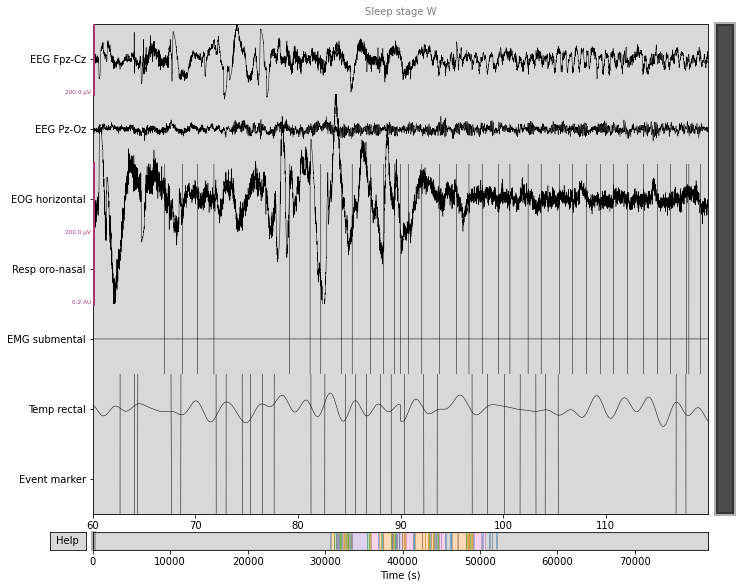

Figure(720x576)


In [67]:
mapping = {'EOG horizontal': 'eog',
           'Resp oro-nasal': 'misc',
           'EMG submental': 'misc',
           'Temp rectal': 'misc',
           'Event marker': 'misc'}

raw_train = mne.io.read_raw_edf(psg_fnames[0])
annot_train = mne.read_annotations(ann_fnames[0])

raw_train.set_annotations(annot_train, emit_warning=False)
raw_train.set_channel_types(mapping)

# plot some data
print(raw_train.plot(start=60, duration=60,
               scalings=dict(eeg=1e-4, resp=1e3, eog=1e-4, emg=1e-7,
                             misc=1e-1)))

Used Annotations descriptions: ['Sleep stage 1', 'Sleep stage 2', 'Sleep stage 3', 'Sleep stage 4', 'Sleep stage R', 'Sleep stage W']


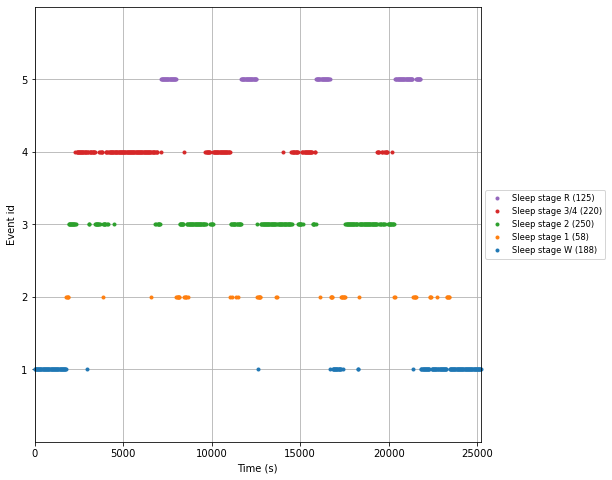

In [68]:
annotation_desc_2_event_id = {'Sleep stage W': 1,
                              'Sleep stage 1': 2,
                              'Sleep stage 2': 3,
                              'Sleep stage 3': 4,
                              'Sleep stage 4': 4,
                              'Sleep stage R': 5}

# keep last 30-min wake events before sleep and first 30-min wake events after
# sleep and redefine annotations on raw data
annot_train.crop(annot_train[1]['onset'] - 30 * 60,
                 annot_train[-2]['onset'] + 30 * 60)
raw_train.set_annotations(annot_train, emit_warning=False)

events_train, _ = mne.events_from_annotations(
    raw_train, event_id=annotation_desc_2_event_id, chunk_duration=30.)

# create a new event_id that unifies stages 3 and 4
event_id = {'Sleep stage W': 1,
            'Sleep stage 1': 2,
            'Sleep stage 2': 3,
            'Sleep stage 3/4': 4,
            'Sleep stage R': 5}

# plot events
fig = mne.viz.plot_events(events_train, event_id=event_id,
                          sfreq=raw_train.info['sfreq'],
                          first_samp=events_train[0, 0])

# keep the color-code for further plotting
stage_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [69]:
events = mne.events_from_annotations(raw_train)[0]
event_id = {'Sleep stage W': 1,
            'Sleep stage 1': 2,
            'Sleep stage 2': 3,
            'Sleep stage 3/4': 4,
            'Sleep stage R': 5}
tmax = 30. - 1. / raw_train.info['sfreq']
epochs_train = mne.Epochs(raw_train, events, tmin=0, tmax=tmax, event_id=event_id,
                    preload=True,baseline=None)

Used Annotations descriptions: ['Sleep stage 1', 'Sleep stage 2', 'Sleep stage 3', 'Sleep stage 4', 'Sleep stage R', 'Sleep stage W']
Not setting metadata
Not setting metadata
141 matching events found
No baseline correction applied
0 projection items activated
Loading data for 141 events and 3000 original time points ...
0 bad epochs dropped


In [70]:
for i in range(1,len(psg_fnames)-4):
    raw_train = mne.io.read_raw_edf(psg_fnames[i])
    annot_train = mne.read_annotations(ann_fnames[i])
    annot_train.crop(annot_train[1]['onset'] - 30 * 60,
                 annot_train[-2]['onset'] + 30 * 60)
    raw_train.set_annotations(annot_train, emit_warning=False)
    events = mne.events_from_annotations(raw_train)[0]
    tmax = 30. - 1. / raw_train.info['sfreq']
    epoch = mne.Epochs(raw_train, events, tmin=0, tmax=tmax, event_id=event_id,
                    preload=True,baseline=None)
    epochs_train = mne.concatenate_epochs([epochs_train, epoch])

Extracting EDF parameters from /home/harsh/Desktop/EEG/sleep_dataset/deepsleepnet-master/data/SC4002E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Used Annotations descriptions: ['Movement time', 'Sleep stage 1', 'Sleep stage 2', 'Sleep stage 3', 'Sleep stage 4', 'Sleep stage R', 'Sleep stage W']
Not setting metadata
Not setting metadata
116 matching events found
No baseline correction applied
0 projection items activated
Loading data for 116 events and 3000 original time points ...
0 bad epochs dropped
Not setting metadata
Not setting metadata
257 matching events found
No baseline correction applied
0 bad epochs dropped
Extracting EDF parameters from /home/harsh/Desktop/EEG/sleep_dataset/deepsleepnet-master/data/SC4011E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Used Annotations descriptions: ['Sleep stage 1', 'Sleep stage 2', 'Sleep stage 3', 'Sleep stage 4', 'Sleep stage R', 'Sleep 

## Visualizations in the dataset

In [99]:
stage_W = len(epochs_train['Sleep stage W'])
stage_1 = len(epochs_train['Sleep stage 1'])
stage_2 = len(epochs_train['Sleep stage 2'])
stage_3 = len(epochs_train['Sleep stage 3/4'])
stage_R = len(epochs_train['Sleep stage R'])

In [71]:
epochs_train

Number of events,4111
Events,Sleep stage 1: 1160Sleep stage 2: 1304Sleep stage 3/4: 758Sleep stage R: 362Sleep stage W: 527
Time range,0.000 – 29.990 sec
Baseline,off


In [324]:
#b = epochs_train.load_data()
#b[0].get_data()[0]  # can calcuate the 3000 values of each channel

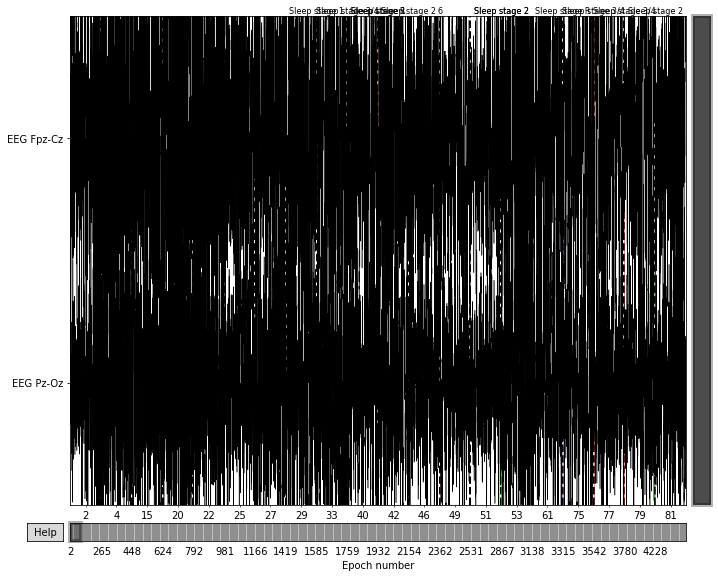

Figure(720x576)


In [76]:
catch_trials_and_buttonpresses = mne.pick_events(events)#, include=[5, 32])
print(epochs_train['Sleep stage 1'].plot(events=catch_trials_and_buttonpresses, event_id=event_id,
                            ))#event_color=dict(button='red', face='blue')))

    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows


<ipython-input-105-7fc473bdfb38>:14: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  print(epochs_train['Sleep stage 1'].plot_psd(picks=channels))


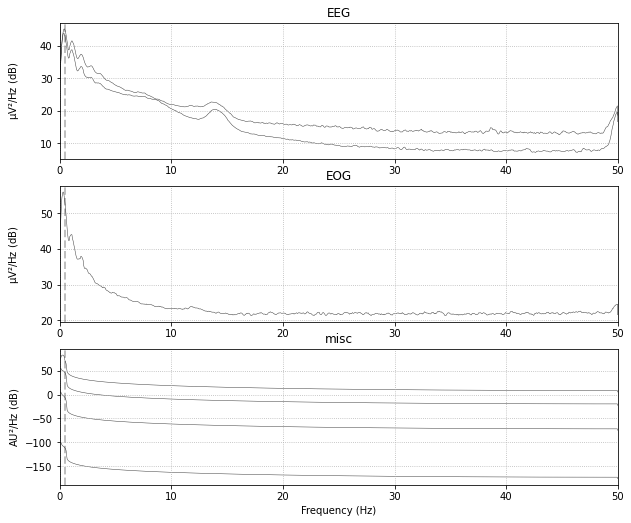

Figure(720x612)


In [105]:
channels = ['EEG Fpz-Cz',
            'EEG Pz-Oz',
            'EOG horizontal',
            'Resp oro-nasal',
            'EMG submental',
            'Temp rectal',
            'Event marker']
stages = ['Sleep stage W',
          'Sleep stage 1',
          'Sleep stage 2',
          'Sleep stage 3/4',
          'Sleep stage R']

print(epochs_train['Sleep stage 1'].plot_psd(picks=channels))

SLEEP STAGE W
Not setting metadata
Not setting metadata
527 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
combining channels using "mean"


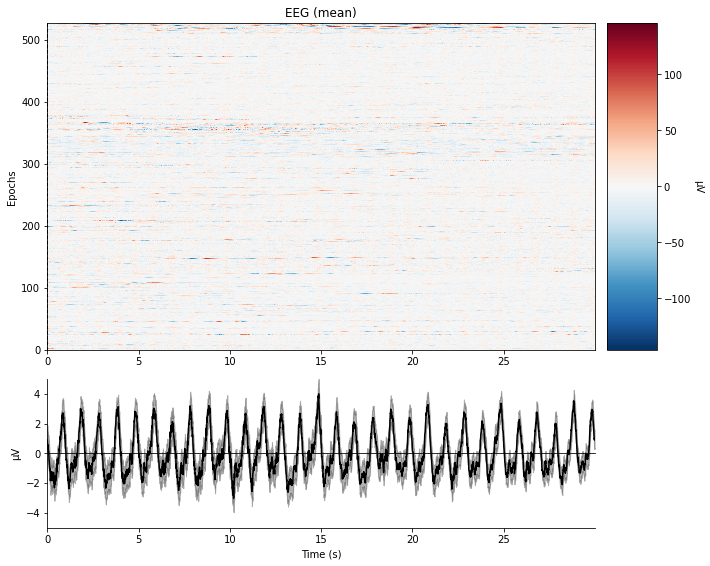

[<Figure size 720x576 with 3 Axes>]
SLEEP STAGE 1
Not setting metadata
Not setting metadata
1160 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
combining channels using "mean"


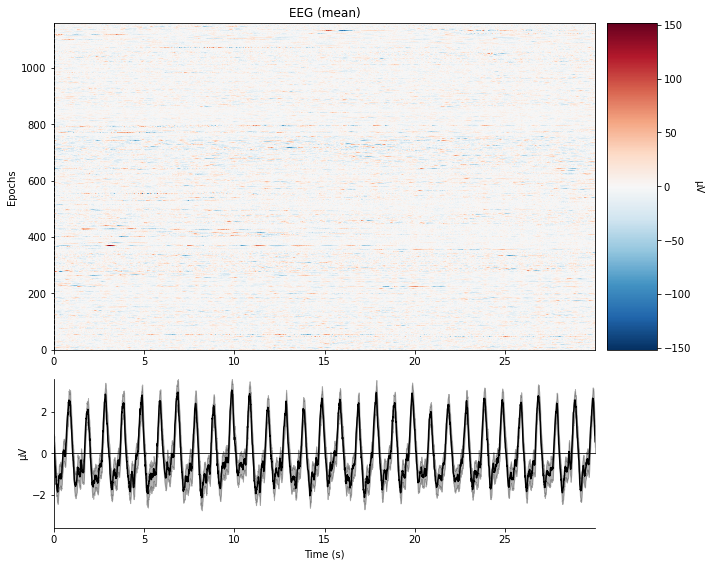

[<Figure size 720x576 with 3 Axes>]
SLEEP STAGE 2
Not setting metadata
Not setting metadata
1304 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
combining channels using "mean"


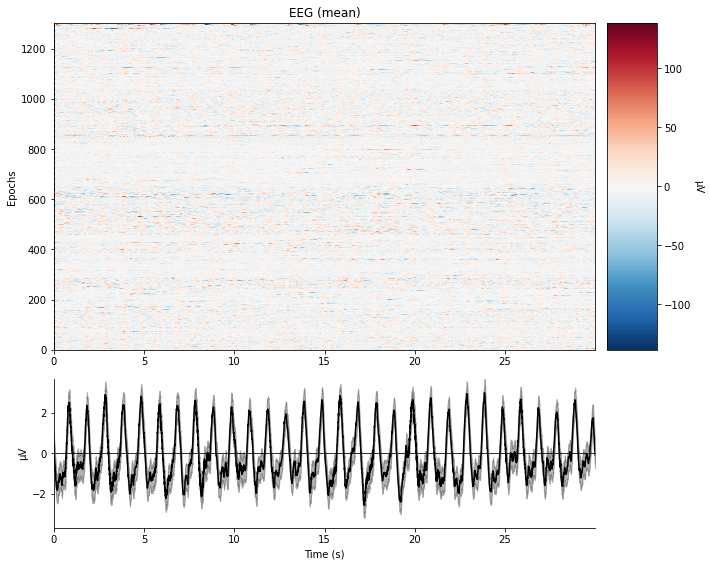

[<Figure size 720x576 with 3 Axes>]
SLEEP STAGE 3/4
Not setting metadata
Not setting metadata
758 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
combining channels using "mean"


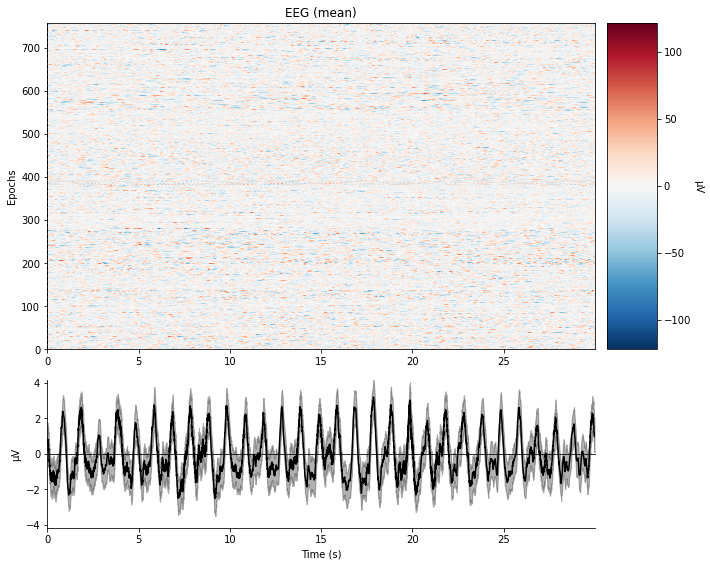

[<Figure size 720x576 with 3 Axes>]
SLEEP STAGE R
Not setting metadata
Not setting metadata
362 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
combining channels using "mean"


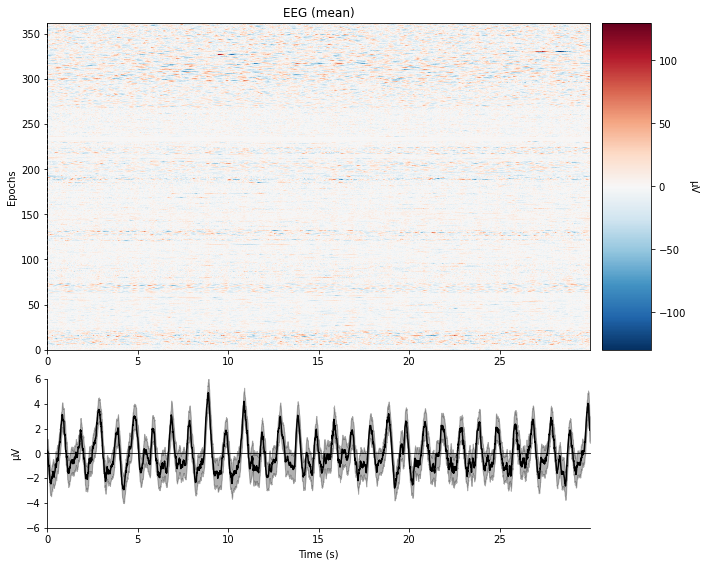

[<Figure size 720x576 with 3 Axes>]


In [107]:
for stage in stages:
    print(stage.upper())
    print(epochs_train[stage].plot_image(picks='data', combine='mean'))

<BarContainer object of 5 artists>

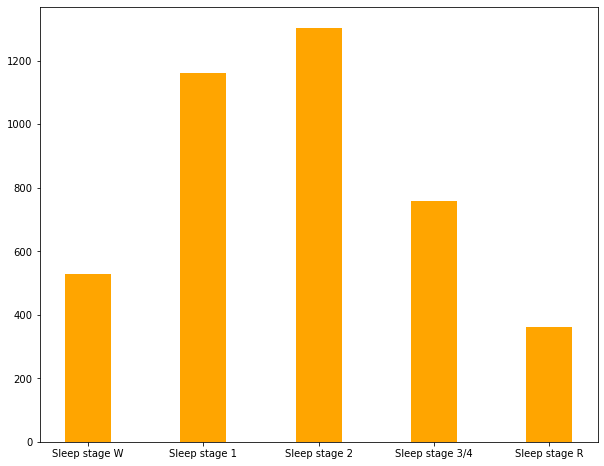

In [116]:
plt.bar(stages, [stage_W,stage_1,stage_2,stage_3,stage_R], color ='orange', width = 0.4)

In [117]:
for i in range(len(psg_fnames)-4,len(psg_fnames)):
    if i == len(psg_fnames)-4:
        raw_test = mne.io.read_raw_edf(psg_fnames[i])
        annot_test = mne.read_annotations(ann_fnames[i])
        annot_test.crop(annot_test[1]['onset'] - 30 * 60,
                 annot_test[-2]['onset'] + 30 * 60)
        raw_test.set_annotations(annot_test, emit_warning=False)
        events = mne.events_from_annotations(raw_test)[0]
        tmax = 30. - 1. / raw_train.info['sfreq']
        epochs_test = mne.Epochs(raw_test, events, tmin=0, tmax=tmax, event_id=event_id,
            preload=True,baseline=None)
    else:
        raw_test = mne.io.read_raw_edf(psg_fnames[i])
        annot_test = mne.read_annotations(ann_fnames[i])
        annot_test.crop(annot_test[1]['onset'] - 30 * 60,
                     annot_test[-2]['onset'] + 30 * 60)
        raw_test.set_annotations(annot_test, emit_warning=False)
        events = mne.events_from_annotations(raw_test)[0]
        tmax = 30. - 1. / raw_test.info['sfreq']
        epoch = mne.Epochs(raw_test, events, tmin=0, tmax=tmax, event_id=event_id,
                        preload=True,baseline=None)
        epochs_test = mne.concatenate_epochs([epochs_test, epoch])

Extracting EDF parameters from /home/harsh/Desktop/EEG/sleep_dataset/deepsleepnet-master/data/SC4181E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Used Annotations descriptions: ['Sleep stage 1', 'Sleep stage 2', 'Sleep stage 3', 'Sleep stage 4', 'Sleep stage R', 'Sleep stage W']
Not setting metadata
Not setting metadata
150 matching events found
No baseline correction applied
0 projection items activated
Loading data for 150 events and 3000 original time points ...
0 bad epochs dropped
Extracting EDF parameters from /home/harsh/Desktop/EEG/sleep_dataset/deepsleepnet-master/data/SC4182E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Used Annotations descriptions: ['Sleep stage 1', 'Sleep stage 2', 'Sleep stage 3', 'Sleep stage 4', 'Sleep stage R', 'Sleep stage W']
Not setting metadata
Not setting metadata
98 matching events found
No baseline correction applied
0 projection items activated


In [119]:
#Observing the power spectral density (PSD) plot of the epochs grouped by sleeping stage we can see that different sleep stages have different signatures. These signatures remain similar between Alice and Bob’s data.

#The rest of this section we will create EEG features based on relative power in specific frequency bands to capture this difference between the sleep stages in our data.

    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows


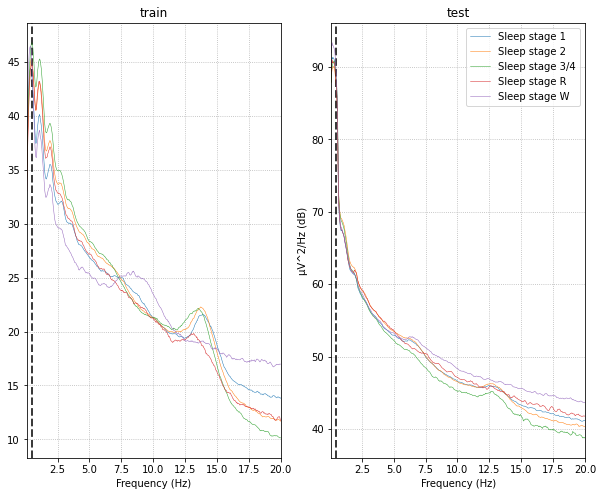

In [147]:
fig, (ax1, ax2) = plt.subplots(ncols=2)

# iterate over the subjects
stages = sorted(event_id.keys())
for ax, title, epochs in zip([ax1, ax2],
                             ['train', 'test'],
                             [epochs_train,epochs_test]):

    for stage, color in zip(stages, stage_colors):
        epochs[stage].plot_psd(area_mode=None, color=color, ax=ax,
                               fmin=0.1, fmax=20., show=False,
                               average=True, spatial_colors=False)
    ax.set(title=title, xlabel='Frequency (Hz)')
ax2.set(ylabel='µV^2/Hz (dB)')
ax2.legend(ax2.lines[2::3], stages)
plt.show()

## Fast Fourier Transformation

In [179]:
psds, freqs = psd_welch(epochs, picks='eeg', fmin=0.5, fmax=30.0)
dt = 0.05
t=np.arange(0,1,dt)
n = len(t)

Effective window size : 2.560 (s)


In [181]:
fhat=np.fft.fft(psds, n)
PSD=fhat*np.conj(fhat)/n
freq=(1/(dt*n))*np.arange(n)
L=np.arange(1, np.floor(n/2), dtype='int')

In [182]:
indices=PSD>1.5
PSDclean=PSD*indices
fhat=indices*fhat
ffilt=np.fft.ifft(fhat)

## Bandpass-filternig

In [134]:
def eeg_power_band(epochs):
    # specific frequency bands
    FREQ_BANDS = {"delta": [0.5, 4.0],
                  "theta": [4.0, 8.0],
                  "alpha": [8.0, 12.0],
                  "sigma": [12.0, 15.0],
                  "beta": [15.0, 30.0]}

    psds, freqs = psd_welch(epochs, picks='eeg', fmin=0.5, fmax=30.0)
    # Normalize the PSDs
    psds /= np.sum(psds, axis=-1, keepdims=True)

    X = []
    for fmin, fmax in FREQ_BANDS.values():
        psds_band = psds[:, :, (freqs >= fmin) & (freqs < fmax)].mean(axis=-1)
        X.append(psds_band.reshape(len(psds), -1))

    return np.concatenate(X, axis=1)

In [136]:
bandpass_filter = FunctionTransformer(eeg_power_band)

In [137]:
a = bandpass_filter.fit_transform(epochs_train)

Effective window size : 2.560 (s)
